In [148]:
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import sklearn

from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Dense, Flatten, Dropout, SimpleRNN, BatchNormalization

import seaborn as sns


####**Описание**

train.csv — личные записи примерно двух третей (~8700) пассажиров, которые будут использоваться в качестве обучающих данных.

PassengerId - Уникальный идентификатор для каждого пассажира. Каждый идентификатор принимает форму, gggg_pp где gggg указывает группу, с которой путешествует пассажир, и pp является их номером в группе. Люди в группе часто являются членами семьи, но не всегда.

HomePlanet- Планета, с которой вылетел пассажир, как правило, планета его постоянного проживания.

CryoSleep - Указывает, решил ли пассажир быть переведен в режим анабиоза на время рейса. Пассажиры, находящиеся в криосонном состоянии, находятся в своих каютах.

Cabin - Номер каюты, в которой находится пассажир. Принимает вид deck/num/side, где side может быть либо P(левый борт) либо S (правый борт).

Destination - Планета, на которую будет высаживаться пассажир.

Age - Возраст пассажира.

VIP - Оплатил ли пассажир специальное VIP-обслуживание во время рейса.

RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Сумма, которую пассажир выставил в счет за каждое из многочисленных роскошных удобств космического корабля Титаник.

Name - Имя и фамилия пассажира.

Transported - Был ли пассажир перенесён в другое измерение.

Это цель, столбец, который вы пытаетесь предсказать.

test.csv — личные записи оставшейся трети (~ 4300) пассажиров, которые будут использоваться в качестве тестовых данных. Ваша задача состоит в том, чтобы предсказать значение Transportedдля пассажиров в этом наборе.

sample_submission.csv — файл отправки в правильном формате. PassengerId- Id для каждого пассажира в тестовом наборе. Transported- Цель. Для каждого пассажира предскажите True или False.

In [149]:
data = pd.read_csv('train.csv')

target = data['Transported']
data_id = data['PassengerId']

df = data.copy()


In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


ФУНКЦИИ

In [151]:
def plt_gr(df):
  fig = plt.figure(figsize = (20,10))
  cols = df.columns
  sns.heatmap(df[cols].isna(), cmap = sns.color_palette())

In [152]:
def fillna_df(df, col, filled):
  df[col] = df[col].fillna(filled)

In [153]:
def split_col(df, col):
  new_df = df[col].str.split('/',expand=True)
  new_df.rename(columns = {0 : 'deck_cabin', 1 : 'num_cabin', 2 : 'side'}, inplace = True) 
  df = pd.concat([df,new_df],axis=1)
  return df

In [154]:
def norm_cols(df, list_col):
  for el in list_col:
    col_max = df[el].astype(float).max()
    df[el] = df [el].apply(lambda x: x/col_max)
    # print(col_max)
  
  return df

### Убираем нули

In [155]:
df = split_col(df,'Cabin' )

In [156]:
df.loc[(df['CryoSleep']== False), 'CryoSleep'] = 0
df.loc[(df['CryoSleep']==True), 'CryoSleep'] = 1

df.loc[(df['VIP']== False), 'VIP'] = 0
df.loc[(df['VIP']==True), 'VIP'] = 1

df.loc[(df['Transported']==False), 'Transported'] = 0
df.loc[(df['Transported']==True), 'Transported'] = 1

target.loc[(target == False)] = 0
target.loc[(target == True)] = 1

df['num_cabin'] = df['num_cabin'].astype(float)

In [157]:
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,deck_cabin,num_cabin,side
0,0001_01,Europa,0,B/0/P,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,B,0.0,P
1,0002_01,Earth,0,F/0/S,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,F,0.0,S
2,0003_01,Europa,0,A/0/S,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,A,0.0,S
3,0003_02,Europa,0,A/0/S,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,A,0.0,S
4,0004_01,Earth,0,F/1/S,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,F,1.0,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,0,A/98/P,55 Cancri e,41.0,1,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,0,A,98.0,P
8689,9278_01,Earth,1,G/1499/S,PSO J318.5-22,18.0,0,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,0,G,1499.0,S
8690,9279_01,Earth,0,G/1500/S,TRAPPIST-1e,26.0,0,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,1,G,1500.0,S
8691,9280_01,Europa,0,E/608/S,55 Cancri e,32.0,0,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,0,E,608.0,S


In [158]:
df.groupby(['deck_cabin' ]).side.value_counts()

deck_cabin  side
A           S        139
            P        117
B           S        426
            P        353
C           S        406
            P        341
D           P        248
            S        230
E           S        447
            P        429
F           P       1438
            S       1356
G           S       1283
            P       1276
T           P          4
            S          1
Name: side, dtype: int64

In [159]:
col_float = ['RoomService','FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','CryoSleep','num_cabin','Age']
col_str = ['HomePlanet', 'Cabin', 'Destination','VIP','Name']
col_cabin = ['deck_cabin', 'side']

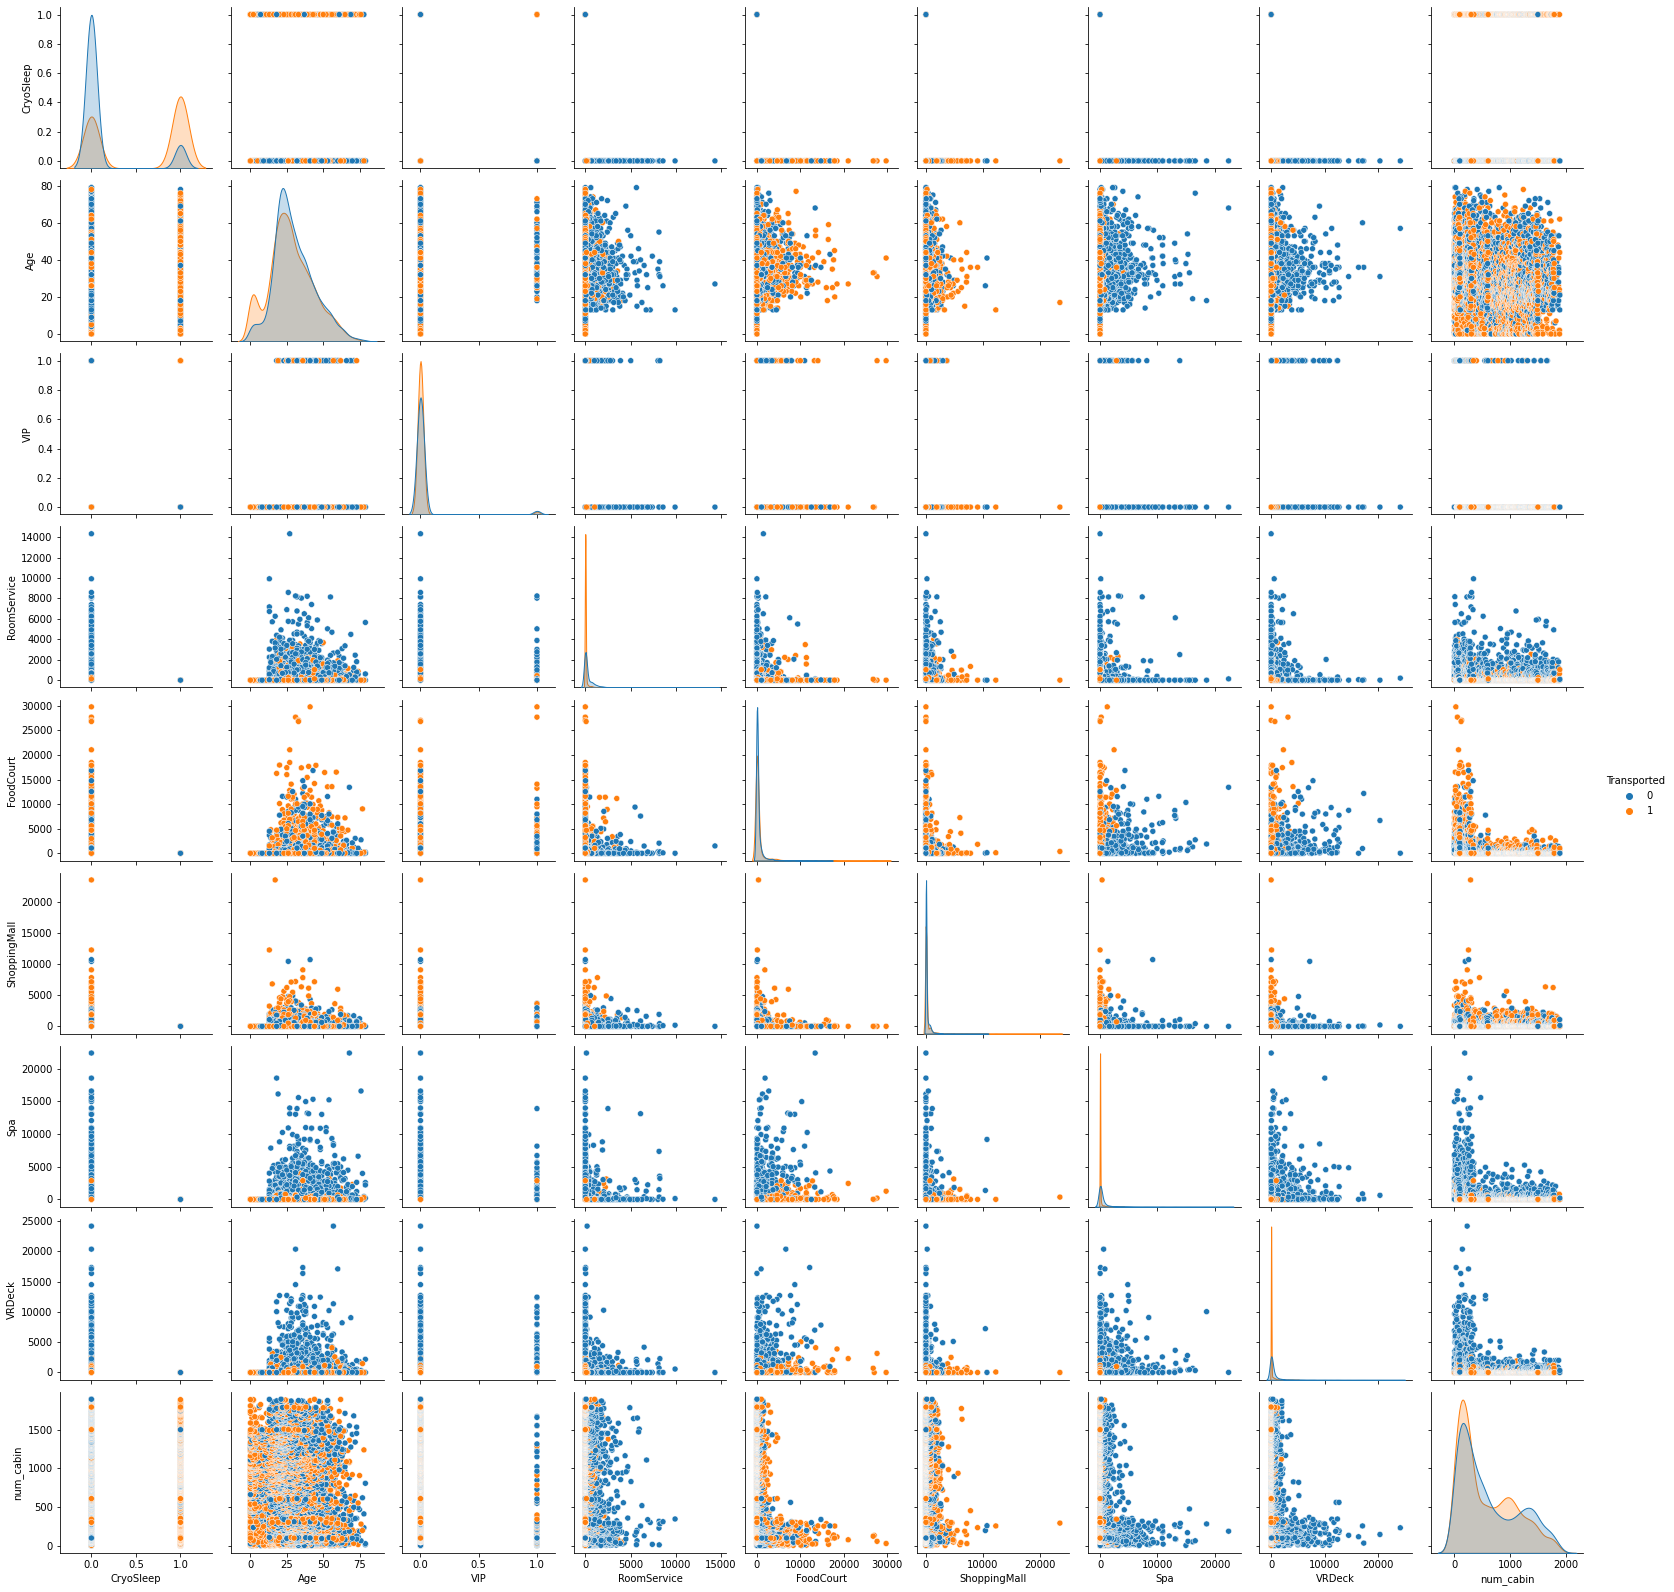

In [160]:
sns.pairplot(df, hue="Transported")

In [161]:
fillna_df(df, col_float, 0)
fillna_df(df, col_str, '0')
fillna_df(df, col_cabin, 'NA')

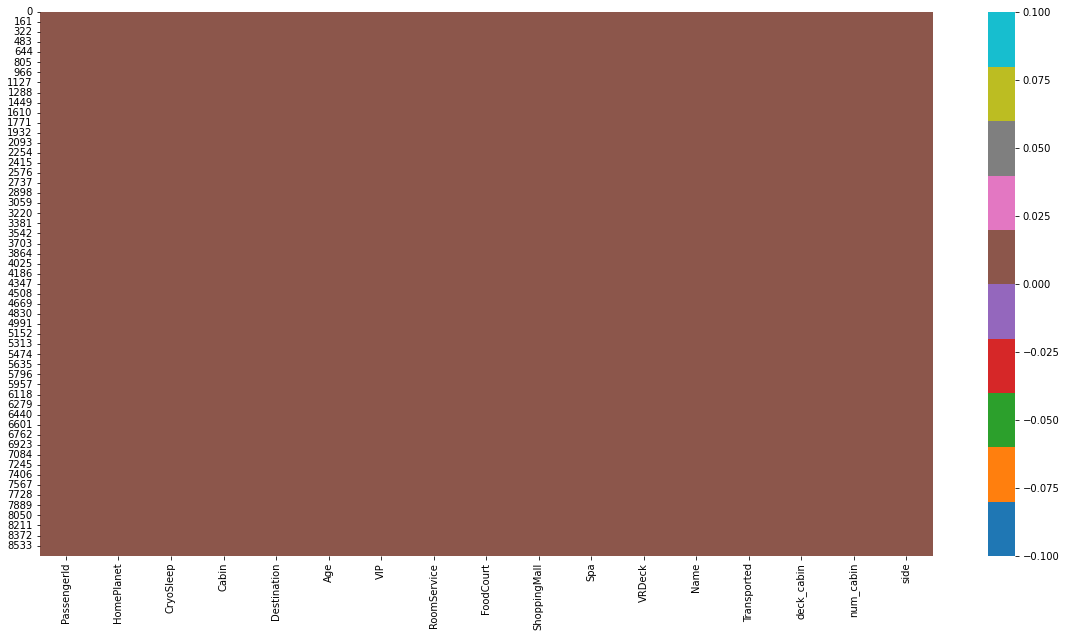

In [162]:
plt_gr(df)

### Нормализуем категориальные данные

In [163]:
cat_features = ['HomePlanet','Destination', 'deck_cabin', 'side']

In [164]:
X = pd.get_dummies(df[cat_features], drop_first=True)


In [165]:
df_onehoten = df.join(X, how='inner')

#### Удаление лишних столбцов

In [166]:
target = df_onehoten['Transported']

In [167]:
df_onehoten = df_onehoten.drop(['PassengerId', 'HomePlanet', 'Cabin', 'Destination',  'Name', 'Transported', 'deck_cabin', 'side'], axis=1)

### Нормализация числовых столбцов

In [168]:
list_norm_col = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall','Spa', 'VRDeck', 'num_cabin']

In [169]:
df_onehoten = norm_cols(df_onehoten, list_norm_col)

In [170]:
df_onehoten

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,num_cabin,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,deck_cabin_B,deck_cabin_C,deck_cabin_D,deck_cabin_E,deck_cabin_F,deck_cabin_G,deck_cabin_NA,deck_cabin_T,side_P,side_S
0,0,0.493671,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0
1,0,0.303797,0,0.007608,0.000302,0.001064,0.024500,0.001823,0.000000,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
2,0,0.734177,1,0.003001,0.119948,0.000000,0.299670,0.002030,0.000000,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3,0,0.417722,0,0.000000,0.043035,0.015793,0.148563,0.007997,0.000000,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,0,0.202532,0,0.021149,0.002348,0.006428,0.025214,0.000083,0.000528,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0,0.518987,1,0.000000,0.228726,0.000000,0.073322,0.003066,0.051742,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0
8689,1,0.227848,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.791447,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
8690,0,0.329114,0,0.000000,0.000000,0.079687,0.000045,0.000000,0.791975,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
8691,0,0.405063,0,0.000000,0.035186,0.000000,0.015753,0.134049,0.321014,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1


**

---



In [171]:
# df_onehoten = df_onehoten.drop(['num_cabin', 'Age'], axis =1)

***

---



In [172]:
df_train = df_onehoten.to_numpy()

In [173]:
target = target.to_numpy()

In [174]:
df_train = np.asarray(df_train).astype('float32')
target = np.asarray(target).astype('float32')

In [175]:
X_train, X_test, y_train, y_test = train_test_split(df_train, target, test_size=0.0001, random_state=42)

In [176]:
# X_train = np.asarray(X_train).astype('float32')
# y_train = np.asarray(y_train).astype('float32')
# X_test = np.asarray(X_test).astype('float32')
# y_test = np.asarray(y_test).astype('float32')
# # target = np.asarray(target).astype('float32')

In [177]:
X_train.shape

(8692, 25)

In [178]:
X_train

array([[0.        , 0.2278481 , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [1.        , 0.51898736, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.443038  , 0.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.        , 0.278481  , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.43037975, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.35443038, 0.        , ..., 0.        , 1.        ,
        0.        ]], dtype=float32)

In [179]:
X_test.shape

(1, 25)

In [189]:
model = keras.Sequential()

model.add(keras.layers.Dense(units=100, activation='relu'))
model.add(BatchNormalization())
model.add(keras.layers.Dropout(0.45))
model.add(keras.layers.Dense(units=100, activation='relu'))
model.add(BatchNormalization(momentum=0.99))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(units=100, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(units=100, activation='relu'))
# model.add(keras.layers.Dropout(0.2))
# model.add(keras.layers.Dense(units=64, activation='relu'))
# model.add(keras.layers.Dropout(0.5))
# model.add(keras.layers.Dense(units=2, activation='relu'))
# model.add(keras.layers.Dense(units=2, activation='relu'))
# model.add(keras.layers.Dense(units=2, activation='softmax'))

model.add(keras.layers.Dense(units=1, activation='sigmoid'))


model.compile(loss= 'log_cosh', optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.05), metrics='acc')

fit_results = model.fit(x=X_train, y=y_train, epochs=200, validation_split=0.25)


Epoch 1/200
204/204 [==============================] - 4s 8ms/step - loss: 0.1017 - acc: 0.6585 - val_loss: 0.0985 - val_acc: 0.7271
Epoch 2/200
204/204 [==============================] - 2s 8ms/step - loss: 0.0909 - acc: 0.7064 - val_loss: 0.0853 - val_acc: 0.7285
Epoch 3/200
204/204 [==============================] - 2s 9ms/step - loss: 0.0882 - acc: 0.7154 - val_loss: 0.0832 - val_acc: 0.7391
Epoch 4/200
204/204 [==============================] - 2s 9ms/step - loss: 0.0878 - acc: 0.7184 - val_loss: 0.0815 - val_acc: 0.7451
Epoch 5/200
204/204 [==============================] - 2s 7ms/step - loss: 0.0862 - acc: 0.7225 - val_loss: 0.0808 - val_acc: 0.7497
Epoch 6/200
204/204 [==============================] - 2s 9ms/step - loss: 0.0851 - acc: 0.7274 - val_loss: 0.0792 - val_acc: 0.7533
Epoch 7/200
204/204 [==============================] - 2s 9ms/step - loss: 0.0835 - acc: 0.7302 - val_loss: 0.0783 - val_acc: 0.7556
Epoch 8/200
204/204 [==============================] - 2s 8ms/step - 

In [181]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_87 (Dense)            (None, 100)               2600      
                                                                 
 batch_normalization_36 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                                 
 dropout_52 (Dropout)        (None, 100)               0         
                                                                 
 dense_88 (Dense)            (None, 100)               10100     
                                                                 
 batch_normalization_37 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                                 
 dropout_53 (Dropout)        (None, 100)             

<function matplotlib.pyplot.legend>

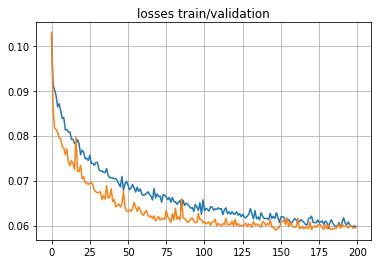

In [182]:
plt.title('losses train/validation')
plt.plot(fit_results.history['loss'], label="Train")
plt.plot(fit_results.history['val_loss'], label="Validation")
plt.grid()
plt.legend

<function matplotlib.pyplot.legend>

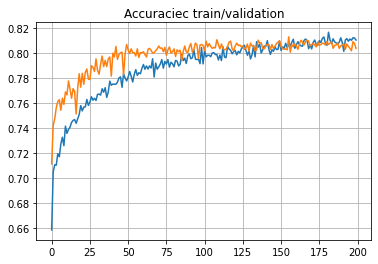

In [183]:
plt.title('Accuraciec train/validation')
plt.plot(fit_results.history['acc'], label="Train")
plt.plot(fit_results.history['val_acc'], label="Validation")
plt.grid()
plt.legend

In [184]:
predicted_test = model.predict(X_test)

In [185]:
test = pd.read_csv('test.csv')

test_id = test['PassengerId']

In [186]:
def testing_model(test):
  test_id = test['PassengerId']
  test = split_col(test,'Cabin' )

  col_float = ['RoomService','FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','CryoSleep','num_cabin','Age']
  col_str = ['HomePlanet', 'Cabin', 'Destination','VIP','Name']
  col_cabin = ['deck_cabin', 'side']

  fillna_df(test, col_float, 0)
  fillna_df(test, col_str, '0')
  fillna_df(test, col_cabin, 'NA')

  test.loc[(test['CryoSleep']== False), 'CryoSleep'] = 0
  test.loc[(test['CryoSleep']==True), 'CryoSleep'] = 1

  test.loc[(test['VIP']== False), 'VIP'] = 0
  test.loc[(test['VIP']==True), 'VIP'] = 1


  test['num_cabin'] = test['num_cabin'].astype(float)

  cat_features = ['HomePlanet','Destination', 'deck_cabin', 'side']

  X = pd.get_dummies(test[cat_features], drop_first=True)
  test_onehoten = test.join(X, how='inner')
  test_onehoten = test_onehoten.drop(['PassengerId', 'HomePlanet', 'Cabin', 'Destination',  'Name', 'deck_cabin', 'side'], axis=1)

  list_norm_col = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall','Spa', 'VRDeck', 'num_cabin']
  test_onehoten = norm_cols(test_onehoten, list_norm_col)

  test_predict = test_onehoten.to_numpy()
  test_onehoten = np.asarray(test_onehoten).astype('float32')

  return model.predict(test_onehoten)


In [187]:
model_predict_test = testing_model(test)

In [188]:
test_data_res = pd.DataFrame(model_predict_test)

res = pd.concat([test_id,test_data_res],axis=1)
res.rename(columns = {0 : 'Transported'}, inplace = True)

res.loc[res['Transported'] < 0.5,'Transported'] = False
res.loc[res['Transported'] >= 0.5,'Transported'] = True

filename = 'Titanic Predictions.csv'
res.to_csv(filename,index=False)
print('Saved file: ' + filename)


Saved file: Titanic Predictions.csv
